## Dataset preparation

In [1]:
import os
from typing import Callable, Tuple
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification: Callable | None = None):
        self.root = root
        self.image_paths = [
            os.path.join(root, f) for f in os.listdir(root) if f.endswith(".png")
        ]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = img.astype(np.float32) / 255.0

        img = self.transform(img)

        if self.modification:
            modified_img = self.modification(img)
        else:
            modified_img = img

        return modified_img, img


In [3]:
def add_random_mask(
    img: torch.Tensor,
    mask_size: tuple[int, int] = (64, 64),
    num_patches: int = 1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a random mask and apply it to the image.
    """
    _, h, w = img.shape
    mask = torch.ones((1, h, w), dtype=img.dtype, device=img.device)

    for _ in range(num_patches):
        # Randomly select the top-left corner of each mask
        x = np.random.randint(0, w - mask_size[0])
        y = np.random.randint(0, h - mask_size[1])

        # Set mask region to zero (black)
        mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Set mask region to zero (black)
    mask[:, y:y+mask_size[1], x:x+mask_size[0]] = 0

    # Apply mask to the image
    masked_img = img * mask

    return masked_img, mask

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%env DIV2K_DATA_PATH=/content/drive/MyDrive/sigk/data/DIV2K

env: DIV2K_DATA_PATH=/content/drive/MyDrive/sigk/data/DIV2K


In [8]:
from torch.utils.data import DataLoader


dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR",
    modification=lambda img: add_random_mask(img, num_patches=3),
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

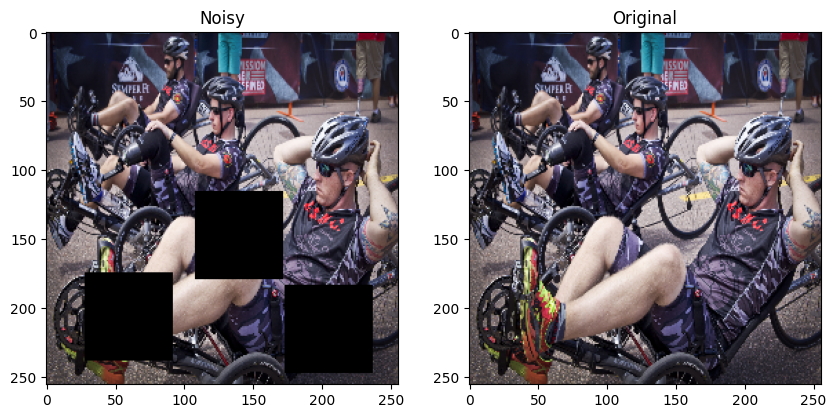

In [9]:
import matplotlib.pyplot as plt

x, y = next(iter(dataloader))
x_, mask = x
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_[0].permute(1, 2, 0))
axs[0].set_title("Noisy")
axs[1].imshow(y[0].permute(1, 2, 0))
axs[1].set_title("Original")
plt.show()

## Model definition

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class PartialConv2d(nn.Module):
    """
    Warstwa częściowej konwolucji:
    - mnoży wejście przez maskę (wyzerowuje piksele zamaskowane),
    - normalizuje wyjście przez liczbę niezamaskowanych pikseli w oknie,
    - aktualizuje maskę (1 jeśli okno ma >0 pikseli, w przeciwnym razie 0).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.mask_conv = nn.Conv2d(1, 1, kernel_size, stride, padding, bias=False)

        # Ustawiamy wagi mask_conv na 1.0
        nn.init.constant_(self.mask_conv.weight, 1.0)

    def forward(self, x, mask):
        """
        x:    (B, C, H, W) - obraz wejściowy (po wyzerowaniu dziur)
        mask: (B, 1, H, W) - maska binarna (1 - piksel istnieje, 0 - dziura)
        """
        # 1) Obliczamy updated_mask - ile pikseli w danym oknie jest != 0
        with torch.no_grad():
            updated_mask = self.mask_conv(mask)
            updated_mask = torch.clamp(updated_mask, min=1e-6)

        # 2) Wyzerowanie dziur
        x_masked = x * mask

        # 3) Zwykła konwolucja, potem normalizacja przez updated_mask
        out = self.conv(x_masked)
        out = out / updated_mask

        # 4) Nowa maska: 1, jeśli okno ma >0 pikseli != 0
        new_mask = (updated_mask > 0).float()

        return out, new_mask

In [101]:
class PartialConvBlock(nn.Module):
    """
    Blok 2 x (PartialConv2d + BN + ReLU)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.partial1 = PartialConv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.partial2 = PartialConv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        # Pierwsza partial conv
        x, mask = self.partial1(x, mask)
        x = self.bn1(x)
        x = self.relu(x)

        # Druga partial conv
        x, mask = self.partial2(x, mask)
        x = self.bn2(x)
        x = self.relu(x)

        return x, mask


class Down(nn.Module):
    """
    Warstwa "Down": ConvBlock -> MaxPool2d
    Zwraca (features, pooled_features, pooled_mask)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = PartialConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x, mask):
        x, mask = self.conv(x, mask)
        x_pooled = self.pool(x)
        mask_pooled = self.pool(mask)
        return x, x_pooled, mask_pooled


class Up(nn.Module):
    """
    Warstwa "Up": Upsample + SkipConnection + PartialConvBlock
    - Używamy Upsample z najbliższym sąsiadem zamiast transponowanej konwolucji
    - Scalanie masek przez mnożenie (pojedynczy kanał)
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = PartialConvBlock(in_channels, out_channels)

    def forward(self, x, skip, mask_x, mask_skip):
        # 1) Powiększamy "głębsze" x + mask_x
        x = self.upsample(x)
        mask_x = self.upsample(mask_x)

        # 2) Interpolujemy skip (opcjonalne), jeśli wymiary nie pasują
        if skip.shape[2:] != x.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='nearest')

        # 3) Konkatenacja cech (x, skip)
        x = torch.cat([x, skip], dim=1)

        # 4) Maska - mnożenie (nie cat!), by nadal mieć 1 kanał
        if mask_skip.shape[2:] != mask_x.shape[2:]:
            mask_skip = F.interpolate(mask_skip, size=mask_x.shape[2:], mode='nearest')
        mask_combined = mask_x * mask_skip

        # 5) PartialConvBlock -> (out, out_mask)
        out, new_mask = self.conv(x, mask_combined)
        return out, new_mask


In [102]:
class PartialInpaintingUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        """
        in_channels=4, bo 3 kanały RGB + 1 kanał maski
        """
        super().__init__()
        #######################################
        # ENCODER
        #######################################
        self.down1 = Down(in_channels, 64)   # out 64
        self.down2 = Down(64, 128)          # out 128
        self.down3 = Down(128, 256)         # out 256
        self.down4 = Down(256, 512)         # out 512

        # Bottleneck
        self.bottleneck = PartialConvBlock(512, 1024)  # out 1024

        #######################################
        # DECODER
        #######################################
        # up1: 1024 (bottleneck) + 512 (skip4) = 1536 -> 512
        self.up1 = Up(1536, 512)
        # up2: 512 + 256 = 768 -> 256
        self.up2 = Up(768, 256)
        # up3: 256 + 128 = 384 -> 128
        self.up3 = Up(384, 128)
        # up4: 128 + 64 = 192 -> 64
        self.up4 = Up(192, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, mask):
        """
        x: (B, 3, H, W) - obraz z dziurami
        mask: (B, 1, H, W) - maska binarna (1: piksel oryginalny, 0: dziura)
        """
        # Łączymy obraz i maskę -> (B, 4, H, W)
        x = torch.cat((x, mask), dim=1)

        #######################################
        # ENCODER
        #######################################
        skip1, d1, mask1 = self.down1(x, mask)      # out: 64
        skip2, d2, mask2 = self.down2(d1, mask1)    # out: 128
        skip3, d3, mask3 = self.down3(d2, mask2)    # out: 256
        skip4, d4, mask4 = self.down4(d3, mask3)    # out: 512

        # Bottleneck
        bottleneck, mask_bottleneck = self.bottleneck(d4, mask4)  # out: 1024

        #######################################
        # DECODER
        #######################################
        # up1 -> (1536 -> 512)
        up1, mask_up1 = self.up1(bottleneck, skip4, mask_bottleneck, mask4)
        # up2 -> (768 -> 256)
        up2, mask_up2 = self.up2(up1, skip3, mask_up1, mask3)
        # up3 -> (384 -> 128)
        up3, mask_up3 = self.up3(up2, skip2, mask_up2, mask2)
        # up4 -> (192 -> 64)
        up4, mask_up4 = self.up4(up3, skip1, mask_up3, mask1)

        # Final output (B, 3, H, W)
        out = self.final_conv(up4)

        # Opcjonalnie przywrócić oryginalne piksele tam, gdzie mask=1:
        # out = mask * x[:, :3, :, :] + (1 - mask) * out

        return out


## Training

In [103]:
import torch.optim as optim
from tqdm import tqdm

In [104]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [105]:
# model = InpaintingUNet()
model = PartialInpaintingUNet(in_channels=4, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = torch.compile(model)
model = model.to(device)

In [106]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.MSELoss,
    optimizer: optim.Adam,
    device: str,
    epochs: int = 5
) -> nn.Module:
    model.train()
    scaler = torch.amp.GradScaler()  # Enables mixed precision training

    for epoch in range(epochs):
        epoch_loss = 0

        for imgs_with_masks, clean_imgs in tqdm(dataloader):
            masked_imgs, masks = imgs_with_masks  # Rozpakowanie poprawione

            # Przenoszenie do GPU
            masked_imgs, masks, clean_imgs = (
                masked_imgs.to(device),
                masks.to(device),
                clean_imgs.to(device),
            )

            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device.type):  # Automatically uses float16
                outputs = model(masked_imgs, masks)
                loss = criterion(outputs, clean_imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    return model


In [107]:
model = train(model, dataloader, criterion, optimizer, device, epochs=5)

100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


Epoch 1/5, Loss: 0.1121


100%|██████████| 50/50 [01:44<00:00,  2.09s/it]


Epoch 2/5, Loss: 0.0779


100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


Epoch 3/5, Loss: 0.0777


100%|██████████| 50/50 [01:42<00:00,  2.06s/it]


Epoch 4/5, Loss: 0.0773


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]

Epoch 5/5, Loss: 0.0776


In [108]:
%env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/sigk/model_checkpoints

env: MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/sigk/model_checkpoints


In [109]:
checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [110]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model, f"{checkpoints_path}/InpaintingUNet_{timestamp}.pt")

In [111]:
eval_dataset = DIV2KDataset(
    root=f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR",
    modification=lambda img: add_random_mask(img, num_patches=3),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [112]:
import matplotlib.pyplot as plt

def visualize_inpainting(model, dataloader, device, num_images=4):
    model.eval()

    with torch.no_grad():
        imgs_with_masks, clean_imgs = next(iter(dataloader))
        masked_imgs, masks = imgs_with_masks
        masked_imgs, masks, clean_imgs = masked_imgs.to(device), masks.to(device), clean_imgs.to(device)

        inpainted_imgs = model(masked_imgs, masks).cpu().permute(0, 2, 3, 1).numpy()

    masked_imgs = masked_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = clean_imgs.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    for i in range(num_images):
        axes[i, 0].imshow(masked_imgs[i])
        axes[i, 0].set_title("Masked Input")

        axes[i, 1].imshow(inpainted_imgs[i])
        axes[i, 1].set_title("Inpainted Output")

        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


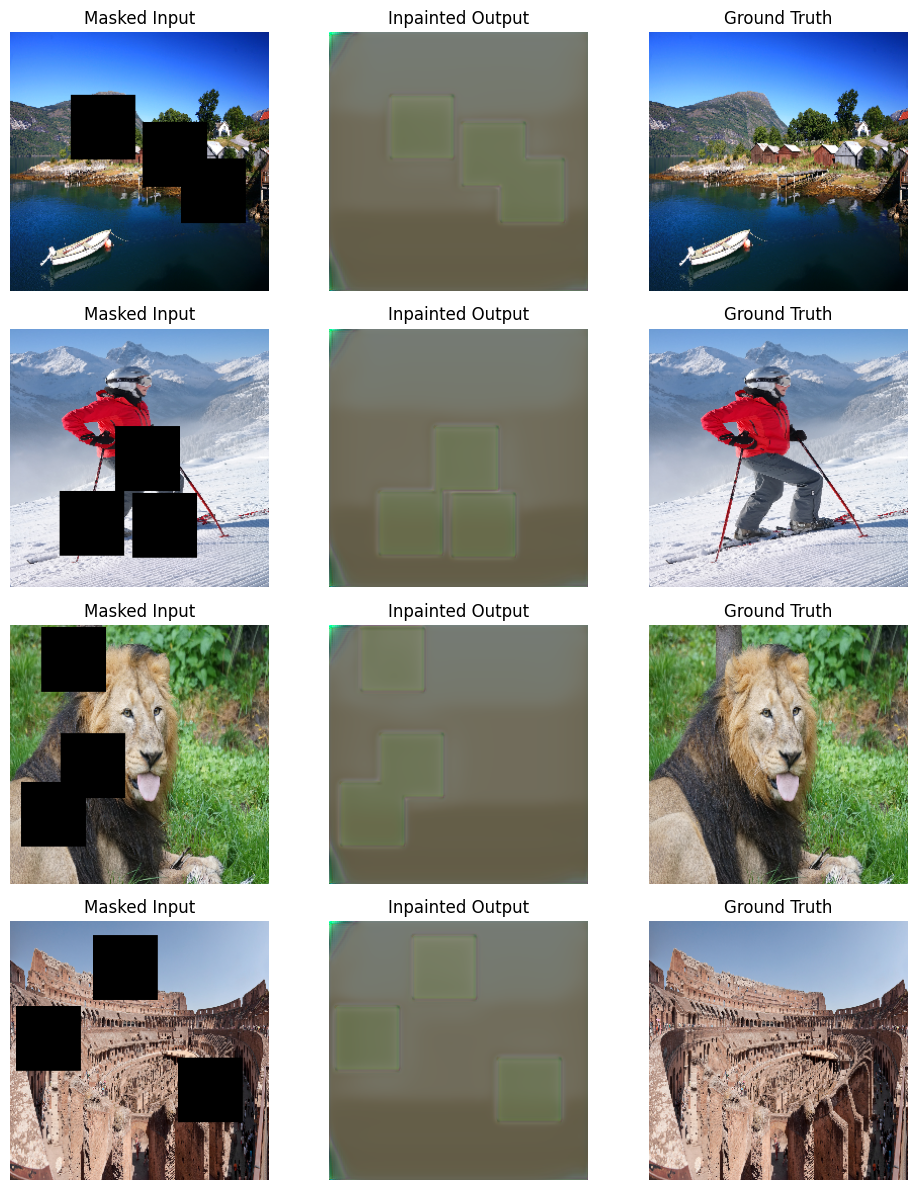

In [113]:
visualize_inpainting(model, eval_dataloader, device)